# Assignment 5: Statistical Analysis (30 pt)

Use as many Python and markdown cells per question as you deem necessary. **DO NOT SUBMIT CODE THAT DOES NOT RUN.** You will lose points for code that throws errors. 

Questions 1 and 2 will use data describing various wetlands, intertidal zones, and ocean conditions in the United States from 1972-2015. This data has been adapted from [publicly available data from NASA](https://daac.ornl.gov/NACP/guides/Tidal_Wetland_Estuaries_Data.html). Note that this file uses the value `-9999` to denote missing data. This file's path is `data/tidal_wetland_estuaries.csv`.

Question 3 will be using time series data describing the proportion of electricity produced by coal in high income countries from [the World Bank](https://data.worldbank.org/indicator/EG.ELC.COAL.ZS). The path to the file is `data/coal-production.csv`.


## Question 1: t-tests (10 pt)

Using the data from `tidal_wetland_estuaries.csv`, test the hypothesis that soil organic carbon density (column name: `soc_density`) is **larger** in the East coast than the West coast with a t-test. Interpret the t-test. (5 pt)

Defend your choice of which type of t-test you used (3 pt).

Do the data meet the requirement for normal data? Why or why not? (2 pt) 

In [44]:
import scipy.stats as stats
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/danimadan/Desktop/GitHub/assignment-5/data/tidal_wetland_estuaries.csv')
df.head()

,name,coast,estu_latitude,estu_longintude,estu_dep,estu_perim,land_area,land_latitude,land_longitude,population,...,ocean_salinity_mean,air_temp_mean,frost_days_per_yr,ocean_sst_mean,ocean_diss_inorg_p,ocean_no3,tide_flow,mean_precip,mean_temp,soc_density
0,Florida Bay,GULF,25.039940,-80.731770,0.62000,614000.000,9.048954e+08,25.187310,-80.727540,3421,...,36.2,24.4,0.0,26.50,0.07,0.810,1.000000e+09,1251.831801,24.594719,0.087
1,South Ten Thousand Islands,GULF,25.311330,-81.057020,0.63000,597000.000,3.069216e+09,25.440250,-80.791070,235792,...,36.1,24.6,0.0,26.40,0.08,0.780,3.000000e+08,1355.907147,24.320596,0.000
2,North Ten Thousand Islands,GULF,25.724280,-81.377640,0.73000,906000.000,4.921106e+09,25.982520,-81.273680,9268,...,36.0,24.1,0.0,26.30,0.09,0.790,6.000000e+08,1416.239789,23.873671,0.084
3,Rookery Bay,GULF,25.998750,-81.756010,0.50000,148000.000,3.304589e+08,26.042920,-81.677710,14858,...,36.0,23.9,0.0,26.10,0.08,0.670,4.000000e+07,1432.519416,23.510000,0.086
4,Charlotte Harbor,GULF,26.754031,-82.103018,1.65938,507261.119,1.169284e+10,27.167615,-81.772154,597644,...,35.9,23.2,1.0,25.65,0.10,0.545,7.000000e+08,1320.275690,22.869199,0.073


In [48]:
eastcoast = df[df['land_longitude']< -80]
westcoast = df[df['land_longitude'] > -120]

t_stat, p_val = ttest_ind(eastcoast['soc_density'].dropna(), westcoast['soc_density'].dropna(), equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: -2.7688762365182873
p-value: 0.006296544089801441


two-tailed test is necessary because you are comparing the difference between means, which could be negative or positive, and thus you must account for both sides of the normal distribution 

The data meet the requirement for normal data because there are enough obervations to assume the central limit theorem applies and run statistical tests with the asumption that the data is normally distributed 

## Question 2

Using the data from `tidal_wetland_estuaries.csv`, create a linear model to predict mean ocean salinity (column name: `ocean_salinity_mean`) from other environmental factors. (2 pt)

Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0. (4 pt)

Interpret the summary of the model, focusing on the R-squared value and the regression coefficients. (3 pt)

Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. (1 pt).

In [39]:
from utils import Linear_Reg_Diagnostic # do not change!
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [40]:

model2 = smf.ols(formula='ocean_salinity_mean~ ocean_no3 + land_area +land_latitude +population' ,data=df).fit()
model2.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ocean_salinity_mean   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                  1.000
Method:                  Least Squares   F-statistic:                 1.038e+07
Date:                 Wed, 10 May 2023   Prob (F-statistic):          1.06e-305
Time:                         16:53:27   Log-Likelihood:                -211.04
No. Observations:                  115   AIC:                             432.1
Df Residuals:                      110   BIC:                             445.8
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        45.4243      0.934     48.641      0.000      43.574      47.275
ocean_no3         1.3922      0.026     52.715      0.000       1.340       1.445
land_area     -2.676e-12    1.8e-12     -1.485      0.140   -6.25e-12    8.95e-13
land_latitude    -0.3877      0.026    -14.733      0.000      -0.440      -0.336
population     1.151e-07   7.09e-08      1.624      0.107   -2.53e-08    2.56e-07
==============================================================================
Omnibus:                        0.894   Durbin-Watson:                   0.224
Prob(Omnibus):                  0.639   Jarque-Bera (JB):                0.848
Skew:                          -0.205   Prob(JB):                        0.654
Kurtosis:                       2.909   Cond. No.                     1.83e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.83e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Question 3 

Using the `coal-production.csv` data, model the proportion of electricity produced with coal in high income countries over time with an ARIMA model. 

Process the data to be useable for time series analysis. (2 pt)

Display your data. Does it appear to have a trend? If so, describe the trend. (1 pt)

Test for stationarity. (1 pt)

Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. What type of ARIMA model was found to be the best fit? (2 pt)

Visualize the fitted values of the ARIMA model, being sure to label each line. (2 pt)

Make a forecast for 25 years after the conclusion of the time series and visualize with observed and fitted values. (2 pt)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
df2 = pd.read_csv('/Users/danimadan/Desktop/GitHub/assignment-5/data/coal-production.csv')
df2.head()

,year,electricity_prod
0,1960,45.904345
1,1961,45.730794
2,1962,46.411172
3,1963,46.599523
4,1964,46.102588


In [27]:
df2['year'] = pd.to_datetime(df2['year'], format='%Y')
df2 = df2.set_index('year').sort_index()



Text(0, 0.5, 'electricity')

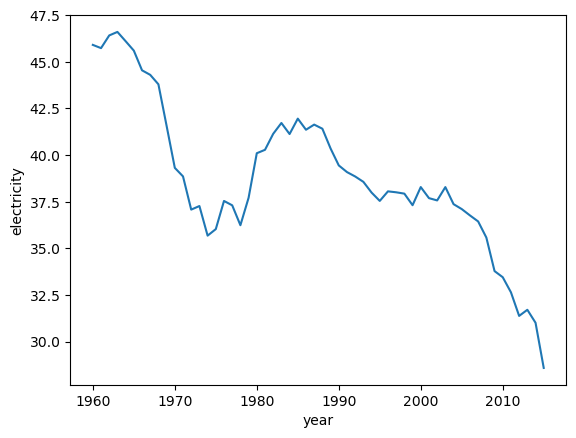

In [28]:
fig, ax = plt.subplots()
ax.plot(df2['electricity_prod']);
ax.set_xlabel('year')
ax.set_ylabel('electricity')

There is a general downward trend with a steep decline in the 1970s, followed by a little bit of an increase in 1980, and it started decreasing again after 1990. 

In [29]:
from statsmodels.tsa.stattools import adfuller

adfuller(df2)

(1.872154432675824,
 0.9984818799941668,
 11,
 44,
 {'1%': -3.5885733964124715,
  '5%': -2.929885661157025,
  '10%': -2.6031845661157025},
 118.46409132638485)

In [30]:
from statsmodels.tsa.arima.model import ARIMA

In [31]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(df2['electricity_prod'])
auto_arima_model.summary()

/Users/danimadan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/danimadan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/danimadan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/danimadan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/danimadan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  ret

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -71.684
Date:                Wed, 10 May 2023   AIC                            149.368
Time:                        16:21:44   BIC                            155.390
Sample:                    01-01-1960   HQIC                           151.697
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8478      0.140      6.074      0.000       0.574       1.121
ma.L1         -0.6020      0.230     -2.622      0.009      -1.052      -0.152
sigma2         0.7894      0.171      4.604      0.000       0.453       1.125
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.68   Prob(JB):                         0.51
Heteroskedasticity (H):               0.72   Skew:                             0.36
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

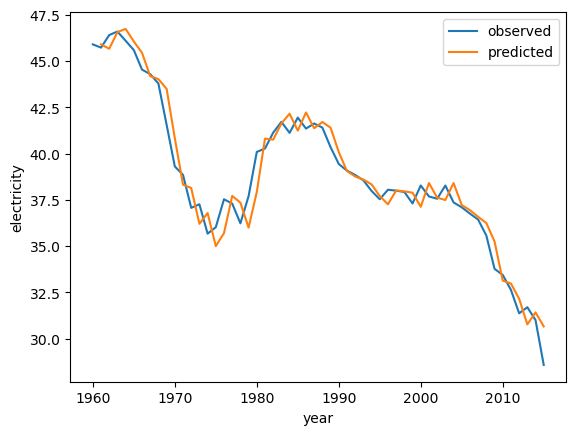

In [32]:
in_samp_pred = auto_arima_model.predict_in_sample()
in_samp_pred = pd.Series(in_samp_pred, index=df2.index)

fig, ax = plt.subplots()
ax.plot(df2, label='observed')
ax.plot(in_samp_pred[1:], label='predicted')
ax.set_xlabel('year')
ax.set_ylabel('electricity')
ax.legend();

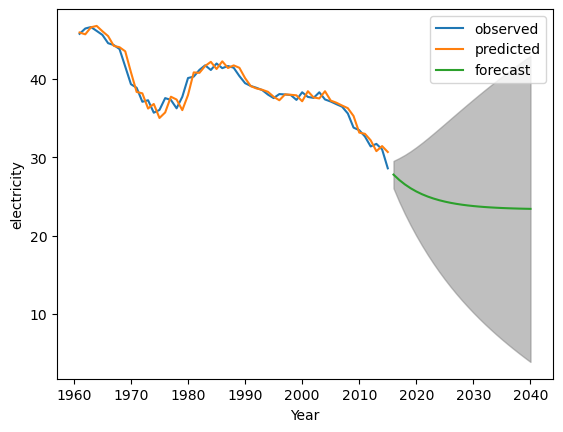

In [33]:
forecast, ci = auto_arima_model.predict(25, return_conf_int=True)
future_dates = pd.date_range(df2.index[-1], periods=26, freq='AS-JAN',inclusive='neither')

fig, ax = plt.subplots()
ax.plot(df2[1:], label='observed')
ax.plot(in_samp_pred[1:], label='predicted')
ax.plot(future_dates,forecast, label='forecast')
ax.fill_between(future_dates, ci[:,0], ci[:,1], color = 'gray', alpha=0.5) 
ax.set_xlabel('Year')
ax.set_ylabel('Electricity')
ax.legend();